# TISSUE gene signatures analysis

This notebook contains code for analyzing and plotting the differential gene signatures analysis using TISSUE. The inputs for this notebook are generated by the experiments using the `get_external_ttest_signatures.py` script. We used the unbiased pathway enrichment from `6C_cellular_proximity_imputation_dgea.ipynb` to select key signatures that may be involved in those effects and included them in our imputation analysis. This is an archival notebook.

**Associated manuscript figures/tables:**
- Figures: 5e,f,g,h

**Inputs required:**
- Outputs from all job parameters associated with `get_external_multi_ttest_signatures.py`:
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_proximity to T cell_Near/`
    - `results/for_imputation/SCPI_k4_k1/SVZDulken_spage_tangram_MI_GENESIG_TTEST_T cell_neighborhood_type_Strong/`
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_proximity to NSC_Near/`
    - `results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_NSC_neighborhood_type_Strong/`
- `results/for_imputation/TcellNSCNeuroblast_subset.h5ad` - AnnData object of coronal sections data subsetted only to T cells, NSCs, Neuroblasts, and neighboring cells (generated from `6A_cellular_proximity_imputation_setup.ipynb`)

**Conda environment used**: `requirements/merfish.txt`

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree
import gseapy as gp

from scipy.stats import mannwhitneyu, ttest_ind
from decimal import Decimal

from ageaccel_proximity import *
from clock_preprocessing import *

In [ ]:
# from TISSUE package

def large_load(dirpath, skipfiles=[]):
    '''
    Loads in anndata and associated pandas dataframe csv files to be added to obsm metadata and uns metadata.
    Input is the directory path to the output directory of large_save()
    
    Parameters
    ----------
        dirpath [str] - path to directory for where outputs of large_save() are located
        skipfiles [list] - list of filenames to exclude from anndata object
    
    Returns
    -------
        adata - AnnData object loaded from dirpath along with all obsm and uns key values added to metadata
    '''
    # read h5ad anndata object
    adata = ad.read_h5ad(os.path.join(dirpath, "adata.h5ad"))
    
    # read and load in obsm from CSV files
    for fn in os.listdir(dirpath):
        if (".csv" in fn) and (fn not in skipfiles):
            df = pd.read_csv(os.path.join(dirpath, fn))
            df.index = adata.obs_names
            key = fn.split(".")[0]
            adata.obsm[key] = df
            
    # read and load any usn metadata from CSV files
    if os.path.isdir(os.path.join(dirpath,"uns")):
        for fn in os.listdir(os.path.join(dirpath,"uns")):
            if (".csv" in fn) and (fn not in skipfiles):
                df = pd.read_csv(os.path.join(dirpath,"uns",fn))
                key = fn.split(".")[0]
                adata.uns[key] = df
            
    return(adata)

In [7]:
# signature mapper

signature_mapper = {'GO_0071346': 'Cellular Response to Type II Interferon',
 'GO_0072584': 'Caveolin-Mediated Endocytosis',
 'GO_0044344': 'Cellular Response to Fibroblast Growth Factor Stimulus',
 'GO_0071560': 'Cellular Response to Transforming Growth Factor Beta Stimulus',
 'GO_0035924': 'Cellular Response to Vascular Endothelial Growth Factor Stimulus',
 'GO_0006635': 'Fatty Acid Beta-Oxidation',
 'GO_0006734': 'NADH Metabolic Process',
 'GO_0090118': 'Receptor-Mediated Endocytosis',
 'GO_0098739': 'Import Across Plasma Membrane',
 'GO_0006887': 'Exocytosis',
 'GO_0022008': 'Neurogenesis',
 'GO_1990182': 'Exosomal Secretion',
 'GO_0032760': 'Positive Regulation of Tumor Necrosis Factor Production',
 'GO_0050852': 'T cell receptor signaling pathway',
 'GO_0032729': 'Positive Regulation of Type II Interferon Production'}

For details on each of the following comparisons, see descriptions under subheadings of the `D4_cellular_proximity_imputation_dgea.ipyn` notebook.

## Near and Far from T cell signatures

In [4]:
# read results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_proximity to T cell_Near",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [ ]:
# rank by most significant signatures

df = adata.uns["spage_Near_Far_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Near_Far_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Near_Far_tstat"].T
df["Tangram t"] = adata.uns["tangram_Near_Far_tstat"].T

df.to_csv("results/for_imputation/dataframes/NvF_Tcell_GO_signature_tests.csv")

## Near and Far from NSC signatures

In [4]:
# read results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_proximity to NSC_Near",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [ ]:
# rank by significance

df = adata.uns["spage_Near_Far_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Near_Far_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Near_Far_tstat"].T
df["Tangram t"] = adata.uns["tangram_Near_Far_tstat"].T

df.to_csv("results/for_imputation/dataframes/NvF_NSC_GO_signature_tests.csv")

## Strong vs Weak T cell signatures

In [4]:
# read results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZDulken_spage_tangram_MI_GENESIG_TTEST_T cell_neighborhood_type_Strong",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [ ]:
# rank by significance

df = adata.uns["spage_Strong_Weak_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Strong_Weak_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Strong_Weak_tstat"].T
df["Tangram t"] = adata.uns["tangram_Strong_Weak_tstat"].T

df.to_csv("results/for_imputation/dataframes/SvW_Tcell_GO_signature_tests.csv")

In [12]:
# interleukin-6 production 0032635
df.loc["GO_0032635"]

SpaGE p      0.216665
Tangram p    0.177555
SpaGE t     -1.235677
Tangram t    1.348338
Name: GO_0032635, dtype: float64

In [10]:
# positive regulation of tumor necrosis factor production 0032760
df.loc["GO_0032760"]

SpaGE p      0.473457
Tangram p    0.235995
SpaGE t     -0.716909
Tangram t    1.185058
Name: GO_0032760, dtype: float64

In [11]:
# positive regulation of type I interferon production 0032481
df.loc["GO_0032481"]

SpaGE p      0.144288
Tangram p    0.169201
SpaGE t      1.461485
Tangram t    1.374779
Name: GO_0032481, dtype: float64

## Strong vs Weak NSC signatures

In [4]:
# read results

adata = large_load("results/for_imputation/SCPI_k4_k1/SVZ_spage_tangram_MI_GENESIG_TTEST_NSC_neighborhood_type_Strong",
                   skipfiles=["tangram_predicted_expression.csv",
                              "tangram_predicted_expression_groups.csv",
                              "tangram_predicted_expression_uncertainty.csv",
                              "spage_predicted_expression.csv",
                              "spage_predicted_expression_groups.csv",
                              "spage_predicted_expression_uncertainty.csv",
                              "knn_predicted_expression.csv",
                              "knn_predicted_expression_groups.csv",
                              "knn_predicted_expression_uncertainty.csv",])

In [ ]:
# rank by significance

df = adata.uns["spage_Strong_Weak_pvalue"].T
df.columns = ["SpaGE p"]
df["Tangram p"] = adata.uns["tangram_Strong_Weak_pvalue"].T

df["SpaGE t"] = adata.uns["spage_Strong_Weak_tstat"].T
df["Tangram t"] = adata.uns["tangram_Strong_Weak_tstat"].T

df.to_csv("results/for_imputation/dataframes/SvW_NSC_GO_signature_tests.csv")

# Statistical testing of individual genes (in the 300 MERFISH gene panel)

This section contains code for testing of gene expression differences in the MERFISH dataset (not imputed), which will be included in the final dot plot visualizations alongside imputed signatures.

In [4]:
filtered_adata = sc.read_h5ad("results/for_imputation/TcellNSCNeuroblast_subset.h5ad")
filtered_adata = normalize_adata(filtered_adata, zscore=False)

## T cell (Near vs Far)

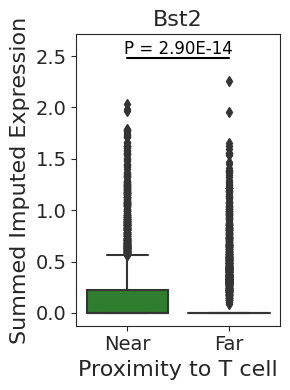

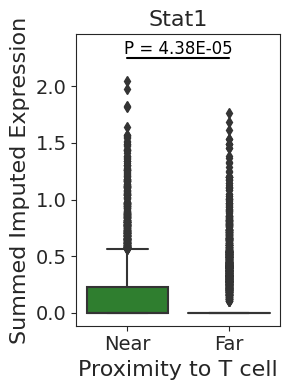

In [11]:
# FINAL FIGURE

signames = ["Bst2", "Stat1"]
marker_names = ["Near", "Far"]
celltype = "T cell"
method = "spage"

exp_palette = {
    "Near":"forestgreen", # forestgreen lightgreen
    "Far":"lightgreen"
}

pvalues = []
ustats = []

#-----------------------------
for signame in signames:

    tag = signame

    obs_key = f"proximity to {celltype}"

    sigvals = np.array(filtered_adata[:,signame].X).flatten()

    x_labels = np.concatenate([[x]*np.sum(filtered_adata.obs[obs_key]==x) for x in marker_names])
    y_values = np.concatenate([sigvals[filtered_adata.obs[obs_key]==x] for x in marker_names]).flatten()
    df = pd.DataFrame(np.vstack((x_labels,y_values)).T, columns=["label","expression"])
    df["expression"] = df["expression"].astype('float')

    fig, ax = plt.subplots(figsize=(3,4))

    sns.boxplot(df,x="label",y="expression",palette=exp_palette)

    # statistical annotation
    x_coords = [0.5]
    y_coords = [np.max(df["expression"])*1.1]
    cols = ['k']
    h = 0
    w = 0.5
    # get p-value from TISSUE results
    u, p = mannwhitneyu(df[df["label"]==marker_names[0]]["expression"],
                     df[df["label"]==marker_names[1]]["expression"])
    pvalues.append(p)
    ustats.append(np.mean(df[df["label"]==marker_names[0]]["expression"])-np.mean(df[df["label"]==marker_names[1]]["expression"]))
    pval_labels = [p]
    for i, label in enumerate(pval_labels):
        p_label = "P = "+ '%.2E' % Decimal(str(label))
        x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
    plt.ylim([None,np.max(df["expression"])*1.2])

    plt.title(f"{signame}", fontsize=16)
    plt.ylabel(f"Normalized Expression", fontsize=16)
    plt.xlabel(f"Proximity to {celltype}", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/mechanism/ViolinGene_{celltype}_{tag}_{method}.pdf",
               bbox_inches='tight')
    plt.show()
    
    
# save dataframe as result
save_df = pd.DataFrame([])
save_df["p"] = pvalues
save_df["u"] = ustats
save_df.index = signames
save_df.to_csv("results/for_imputation/dataframes/NvF_Tcell_gene_mannwhitney.csv")

## NSC (Strong vs Weak)

0.02773710904231813


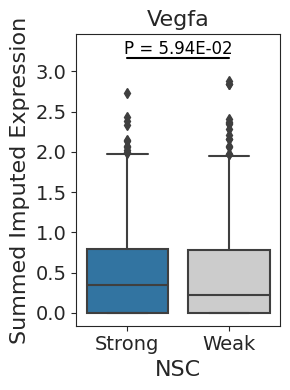

0.03097153562283106


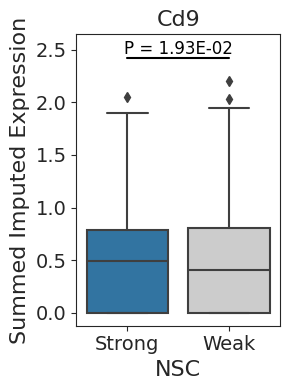

In [13]:
# FINAL FIGURE

signames = ["Vegfa", "Cd9"]
marker_names = ["Strong", "Weak"]
celltype = "NSC"
method = "spage"

exp_palette = {
    "Strong":"tab:blue",
    "Weak":"0.8"
}

pvalues = []
ustats = []

#-----------------------------
for signame in signames:

    tag = signame

    obs_key = f"{celltype}_neighborhood_type"

    sigvals = np.array(filtered_adata[:,signame].X).flatten()

    x_labels = np.concatenate([[x]*np.sum(filtered_adata.obs[obs_key]==x) for x in marker_names])
    y_values = np.concatenate([sigvals[filtered_adata.obs[obs_key]==x] for x in marker_names]).flatten()
    df = pd.DataFrame(np.vstack((x_labels,y_values)).T, columns=["label","expression"])
    df["expression"] = df["expression"].astype('float')

    fig, ax = plt.subplots(figsize=(3,4))

    sns.boxplot(df,x="label",y="expression",palette=exp_palette)

    # statistical annotation
    x_coords = [0.5]
    y_coords = [np.max(df["expression"])*1.1]
    cols = ['k']
    h = 0
    w = 0.5
    # get p-value from TISSUE results
    u, p = mannwhitneyu(df[df["label"]==marker_names[0]]["expression"],
                     df[df["label"]==marker_names[1]]["expression"])
    pvalues.append(p)
    ustats.append(np.mean(df[df["label"]==marker_names[0]]["expression"])-np.mean(df[df["label"]==marker_names[1]]["expression"]))
    print(np.mean(df[df["label"]==marker_names[0]]["expression"])-np.mean(df[df["label"]==marker_names[1]]["expression"]))
    pval_labels = [p]
    for i, label in enumerate(pval_labels):
        p_label = "P = "+ '%.2E' % Decimal(str(label))
        x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=12)
    plt.ylim([None,np.max(df["expression"])*1.2])

    plt.title(f"{signame}", fontsize=16)
    plt.ylabel(f"Normalized Expression", fontsize=16)
    plt.xlabel(f"{celltype}", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/mechanism/ViolinGene_StrongWeak_{celltype}_{tag}_{method}.pdf",
               bbox_inches='tight')
    plt.show()
    
# save dataframe as result
save_df = pd.DataFrame([])
save_df["p"] = pvalues
save_df["u"] = ustats
save_df.index = signames
save_df.to_csv("results/for_imputation/dataframes/SvW_NSC_gene_mannwhitney.csv")

## Check to see cell type matching is generally balanced

In [64]:
pd.DataFrame(np.unique(filtered_adata[filtered_adata.obs["proximity to NSC"]=="Near"].obs.celltype,
          return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Astrocyte,Endothelial,Ependymal,Macrophage,Microglia,NSC,Neuroblast,Neuron-Excitatory,Neuron-MSN,OPC,Oligodendrocyte,Pericyte,T cell,VSMC
1,949,277,936,11,135,33,564,5,242,87,702,72,8,11


In [65]:
pd.DataFrame(np.unique(filtered_adata[filtered_adata.obs["proximity to NSC"]=="Far"].obs.celltype,
          return_counts=True))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Astrocyte,Endothelial,Ependymal,Macrophage,Microglia,NSC,Neuroblast,Neuron-Excitatory,Neuron-MSN,OPC,Oligodendrocyte,Pericyte,T cell,VSMC
1,949,277,933,9,135,22,553,4,242,87,702,72,7,10


# Dot Plots showing key signatures and genes

## Strong T cell vs Weak T cell

In [10]:
# Strong vs Weak T cells

signames = ['GO_0032729', 'GO_0050852'] # GO_0072678

df1 = pd.read_csv("results/for_imputation/dataframes/SvW_Tcell_GO_signature_tests.csv", index_col=0)

# process GO BP signatures df
df1 = df1.loc[signames]
df1["-log p-value"] = -np.log10(df1["SpaGE p"])
df1["signature"] = [signature_mapper[x] for x in df1.index]
df1["up_down"] = ["up" if x > 0 else "down" for x in df1["SpaGE t"]]
df1 = df1[["signature","-log p-value","up_down"]]

# combine dataframes
df = df1
df

,signature,-log p-value,up_down
GO_0032729,Positive Regulation of Type II Interferon Prod...,1.591365,up
GO_0050852,T cell receptor signaling pathway,2.056553,up


/local/scratch/edsun/slrmtmp.42144306/ipykernel_48130/4129118754.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
/local/scratch/edsun/slrmtmp.42144306/ipykernel_48130/4129118754.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


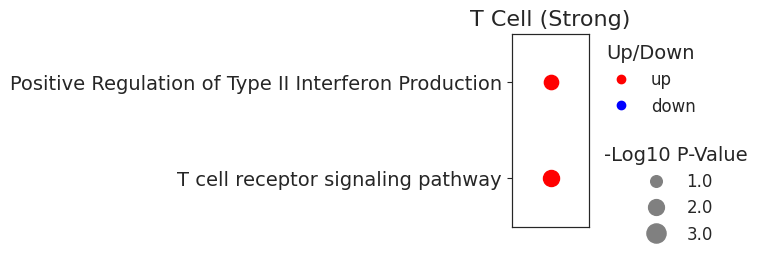

In [11]:
circle1size = -np.log10(0.1)
circle2size = -np.log10(0.01)
circle3size = -np.log10(0.001)


#---------------------------------------------------

# Invert the row order
df = df[::-1]

# Mapping colors for "up" and "down"
colors = {"up": "red", "down": "blue"}

# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(1, 2.5))

# Define the size range for circles based on p-values
size_min, size_max = 10, 70  # You can adjust these values
df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
size1 = size_min + (size_max - size_min) * circle1size
size2 = size_min + (size_max - size_min) * circle2size
size3 = size_min + (size_max - size_min) * circle3size


# Plot the vertical dot plot
for index, row in df.iterrows():
    size = row["circle_size"]
    color = colors[row["up_down"]]
    ax.scatter([1], [index], s=size, c=color, label=row["signature"])

# Remove x-axis ticks
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=14)

# Remove y-axis ticks on the second y-axis
ax2 = ax.twinx()
ax2.set_yticks([])

# Set y-tick labels to signature and adjust position
ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(df["signature"])

# Set axis labels and title
ax.set_title("T Cell (Strong)", fontsize=16)

# Create a legend for p-values with specified circles
p_value_legend = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size1), linestyle='None', label=str(circle1size), color='gray')
p_value_legend_2 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size2), linestyle='None', label=str(circle2size), color='gray')
p_value_legend_3 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size3), linestyle='None', label=str(circle3size), color='gray')

ax2.legend(handles=[p_value_legend, p_value_legend_2, p_value_legend_3], title="-Log10 P-Value", loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Create a second legend for "up_down" colors
handles = [plt.Line2D([], [], marker='o', color=color, linestyle='None', label=label) for label, color in colors.items()]
ax.legend(handles=handles, title="Up/Down", loc='lower left', bbox_to_anchor=(1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Adjust the y-axis and decrease whitespace margins
ax.set_ylim(-0.5, len(df) - 0.5)
ax.set_xlim(0.75, 1.25)  # Adjust the x-axis limit

# Show the plot
plt.tight_layout()
plt.savefig("plots/mechanism/DotPlot_SvW_Tcell.pdf", bbox_inches='tight')
plt.show()

## Near T cell vs Far T cell

In [24]:
# Near T cell vs Far T cell

signames = ['GO_0071346']


df1 = pd.read_csv("results/for_imputation/dataframes/NvF_Tcell_GO_signature_tests.csv", index_col=0)
df2 = pd.read_csv("results/for_imputation/dataframes/NvF_Tcell_gene_mannwhitney.csv", index_col=0)

# process GO BP signatures df
df1 = df1.loc[signames]
df1["-log p-value"] = -np.log10(df1["SpaGE p"])
df1["signature"] = [signature_mapper[x] for x in df1.index]
df1["up_down"] = ["up" if x > 0 else "down" for x in df1["SpaGE t"]]
df1 = df1[["signature","-log p-value","up_down"]]

# process measured gene tests df
df2["-log p-value"] = -np.log10(df2["p"])
df2["signature"] = df2.index
df2["up_down"] = ["up" if x > 0 else "down" for x in df2["u"]]
df2 = df2[["signature","-log p-value","up_down"]]

# combine dataframes
df = pd.concat((df1,df2))
df

,signature,-log p-value,up_down
GO_0071346,Cellular Response to Type II Interferon,3.636775,up
Bst2,Bst2,13.538203,up
Stat1,Stat1,4.358108,up


/local/scratch/edsun/slrmtmp.42113657/ipykernel_53540/2468257865.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
/local/scratch/edsun/slrmtmp.42113657/ipykernel_53540/2468257865.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


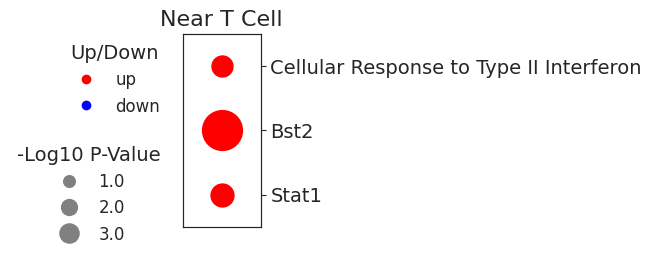

In [25]:
circle1size = -np.log10(0.1)
circle2size = -np.log10(0.01)
circle3size = -np.log10(0.001)


#---------------------------------------------------

# Invert the row order
df = df[::-1]

# Mapping colors for "up" and "down"
colors = {"up": "red", "down": "blue"}

# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(1, 2.5))

# Define the size range for circles based on p-values
size_min, size_max = 10, 70  # You can adjust these values
df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
size1 = size_min + (size_max - size_min) * circle1size
size2 = size_min + (size_max - size_min) * circle2size
size3 = size_min + (size_max - size_min) * circle3size


# Plot the vertical dot plot
for index, row in df.iterrows():
    size = row["circle_size"]
    color = colors[row["up_down"]]
    ax.scatter([1], [index], s=size, c=color, label=row["signature"])

# Remove x-axis ticks
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(df["signature"])

# Set y-tick labels to signature and adjust position
ax2 = ax.twinx()
ax2.set_yticks([])
ax.yaxis.tick_right()

# Set axis labels and title
ax.set_title("Near T Cell", fontsize=16)

# Create a legend for p-values with specified circles
p_value_legend = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size1), linestyle='None', label=str(circle1size), color='gray')
p_value_legend_2 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size2), linestyle='None', label=str(circle2size), color='gray')
p_value_legend_3 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size3), linestyle='None', label=str(circle3size), color='gray')

ax2.legend(handles=[p_value_legend, p_value_legend_2, p_value_legend_3], title="-Log10 P-Value", loc='upper right', bbox_to_anchor=(-0.1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Create a second legend for "up_down" colors
handles = [plt.Line2D([], [], marker='o', color=color, linestyle='None', label=label) for label, color in colors.items()]
ax.legend(handles=handles, title="Up/Down", loc='lower right', bbox_to_anchor=(-0.1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Adjust the y-axis and decrease whitespace margins
ax.set_ylim(-0.5, len(df) - 0.5)
ax.set_xlim(0.75, 1.25)  # Adjust the x-axis limit

# Show the plot
plt.tight_layout()
plt.savefig("plots/mechanism/DotPlot_NvF_Tcell.pdf", bbox_inches='tight')
plt.show()

## Strong NSC vs Weak NSC

In [20]:
# Strong NSC vs Weak NSC

signames = ['GO_0022008', 'GO_0006887', 'GO_1990182']
genenames = ["Cd9", "Vegfa"]


df1 = pd.read_csv("results/for_imputation/dataframes/SvW_NSC_GO_signature_tests.csv", index_col=0)
df2 = pd.read_csv("results/for_imputation/dataframes/SvW_NSC_gene_mannwhitney.csv", index_col=0)

# process GO BP signatures df
df1 = df1.loc[signames]
df1["-log p-value"] = -np.log10(df1["SpaGE p"])
df1["signature"] = [signature_mapper[x] for x in df1.index]
df1["up_down"] = ["up" if x > 0 else "down" for x in df1["SpaGE t"]]
df1 = df1[["signature","-log p-value","up_down"]]

# process measured gene tests df
df2 = df2.loc[genenames]
df2["-log p-value"] = -np.log10(df2["p"])
df2["signature"] = df2.index
df2["up_down"] = ["up" if x > 0 else "down" for x in df2["u"]]
df2 = df2[["signature","-log p-value","up_down"]]

# combine dataframes
df = pd.concat((df1,df2))
df

,signature,-log p-value,up_down
GO_0022008,Neurogenesis,1.239264,up
GO_0006887,Exocytosis,1.857097,up
GO_1990182,Exosomal Secretion,1.361021,up
Cd9,Cd9,1.713973,up
Vegfa,Vegfa,1.225933,up


/local/scratch/edsun/slrmtmp.42167689/ipykernel_37557/281157396.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
/local/scratch/edsun/slrmtmp.42167689/ipykernel_37557/281157396.py:62: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


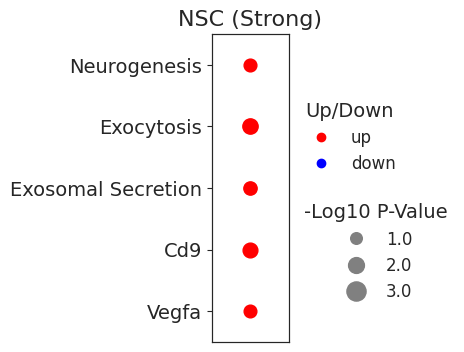

In [22]:
circle1size = -np.log10(0.1)
circle2size = -np.log10(0.01)
circle3size = -np.log10(0.001)


#---------------------------------------------------

# Invert the row order
df = df[::-1]

# Mapping colors for "up" and "down"
colors = {"up": "red", "down": "blue"}

# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(1, 4))

# Define the size range for circles based on p-values
size_min, size_max = 10, 70  # You can adjust these values
df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
size1 = size_min + (size_max - size_min) * circle1size
size2 = size_min + (size_max - size_min) * circle2size
size3 = size_min + (size_max - size_min) * circle3size


# Plot the vertical dot plot
for index, row in df.iterrows():
    size = row["circle_size"]
    color = colors[row["up_down"]]
    ax.scatter([1], [index], s=size, c=color, label=row["signature"])

# Remove x-axis ticks
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=14)

# Remove y-axis ticks on the second y-axis
ax2 = ax.twinx()
ax2.set_yticks([])

# Set y-tick labels to signature and adjust position
ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(df["signature"])

# Set axis labels and title
ax.set_title("NSC (Strong)", fontsize=16)

# Create a legend for p-values with specified circles
p_value_legend = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size1), linestyle='None', label=str(circle1size), color='gray')
p_value_legend_2 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size2), linestyle='None', label=str(circle2size), color='gray')
p_value_legend_3 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size3), linestyle='None', label=str(circle3size), color='gray')

ax2.legend(handles=[p_value_legend, p_value_legend_2, p_value_legend_3], title="-Log10 P-Value", loc='upper left', bbox_to_anchor=(1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Create a second legend for "up_down" colors
handles = [plt.Line2D([], [], marker='o', color=color, linestyle='None', label=label) for label, color in colors.items()]
ax.legend(handles=handles, title="Up/Down", loc='lower left', bbox_to_anchor=(1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Adjust the y-axis and decrease whitespace margins
ax.set_ylim(-0.5, len(df) - 0.5)
ax.set_xlim(0.75, 1.25)  # Adjust the x-axis limit

# Show the plot
plt.tight_layout()
plt.savefig("plots/mechanism/DotPlot_SvW_NSC.pdf", bbox_inches='tight')
plt.show()

## Near NSC vs Far NSC

In [15]:
# Near vs Far NSC

signames = ['GO_0072584',"GO_0090118", "GO_0098739",
            'GO_0035924','GO_0044344','GO_0071560',
            'GO_0006635','GO_0006734']

df1 = pd.read_csv("results/for_imputation/dataframes/NvF_NSC_GO_signature_tests.csv", index_col=0)

# process GO BP signatures df
df1 = df1.loc[signames]
df1["-log p-value"] = -np.log10(df1["SpaGE p"])
df1["signature"] = [signature_mapper[x] for x in df1.index]
df1["up_down"] = ["up" if x > 0 else "down" for x in df1["SpaGE t"]]
df1 = df1[["signature","-log p-value","up_down"]]

# combine dataframes
df = df1
df

,signature,-log p-value,up_down
GO_0072584,Caveolin-Mediated Endocytosis,4.710670,up
GO_0090118,Receptor-Mediated Endocytosis,2.145157,up
GO_0098739,Import Across Plasma Membrane,1.774127,up
GO_0035924,Cellular Response to Vascular Endothelial Grow...,3.256826,up
GO_0044344,Cellular Response to Fibroblast Growth Factor ...,12.484768,up
GO_0071560,Cellular Response to Transforming Growth Facto...,9.154682,up
GO_0006635,Fatty Acid Beta-Oxidation,14.085358,up
GO_0006734,NADH Metabolic Process,8.818901,up


/local/scratch/edsun/slrmtmp.42113657/ipykernel_53540/1851635556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
/local/scratch/edsun/slrmtmp.42113657/ipykernel_53540/1851635556.py:61: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


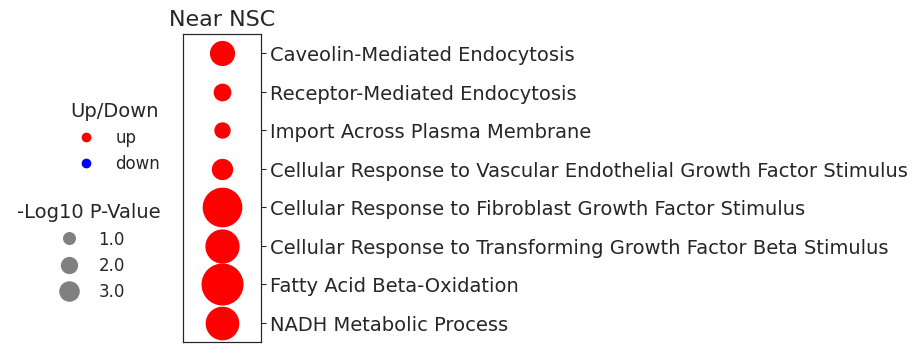

In [29]:
circle1size = -np.log10(0.1)
circle2size = -np.log10(0.01)
circle3size = -np.log10(0.001)


#---------------------------------------------------

# Invert the row order
df = df[::-1]

# Mapping colors for "up" and "down"
colors = {"up": "red", "down": "blue"}

# Create a figure with the desired size
fig, ax = plt.subplots(figsize=(1, 4))

# Define the size range for circles based on p-values
size_min, size_max = 10, 70  # You can adjust these values
df["circle_size"] = size_min + (size_max - size_min) * df["-log p-value"]
size1 = size_min + (size_max - size_min) * circle1size
size2 = size_min + (size_max - size_min) * circle2size
size3 = size_min + (size_max - size_min) * circle3size


# Plot the vertical dot plot
for index, row in df.iterrows():
    size = row["circle_size"]
    color = colors[row["up_down"]]
    ax.scatter([1], [index], s=size, c=color, label=row["signature"])

# Remove x-axis ticks
ax.set_xticks([])
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_yticks(np.arange(len(df)))
ax.set_yticklabels(df["signature"])

# Set y-tick labels to signature and adjust position
ax2 = ax.twinx()
ax2.set_yticks([])
ax.yaxis.tick_right()

# Set axis labels and title
ax.set_title("Near NSC", fontsize=16)

# Create a legend for p-values with specified circles
p_value_legend = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size1), linestyle='None', label=str(circle1size), color='gray')
p_value_legend_2 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size2), linestyle='None', label=str(circle2size), color='gray')
p_value_legend_3 = plt.Line2D([0], [0], marker='o', markersize=np.sqrt(size3), linestyle='None', label=str(circle3size), color='gray')

ax2.legend(handles=[p_value_legend, p_value_legend_2, p_value_legend_3], title="-Log10 P-Value", loc='upper right', bbox_to_anchor=(-0.1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Create a second legend for "up_down" colors
handles = [plt.Line2D([], [], marker='o', color=color, linestyle='None', label=label) for label, color in colors.items()]
ax.legend(handles=handles, title="Up/Down", loc='lower right', bbox_to_anchor=(-0.1, 0.5), frameon=False, title_fontsize=14, fontsize=12)

# Adjust the y-axis and decrease whitespace margins
ax.set_ylim(-0.5, len(df) - 0.5)
ax.set_xlim(0.75, 1.25)  # Adjust the x-axis limit

# Show the plot
plt.tight_layout()
plt.savefig("plots/mechanism/DotPlot_NvF_NSC.pdf", bbox_inches='tight')
plt.show()